In [47]:
import openpyxl
import mne
import mnelab
import numpy
import matplotlib
import xgboost
import pyriemann
import scipy
import pickle
import numpy as np
import pandas as pd
import FeatureExtract
import pybv
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, KFold
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from mne.decoding import CSP
import seaborn as sns

In [2]:
# 行列标识符
chars = {'A': (1, 7), 'B': (1, 8), 'C': (1, 9), 'D': (1, 10), 'E': (1, 11), 'F': (1, 12), 
         'G': (2, 7), 'H': (2, 8), 'I': (2, 9), 'J': (2, 10), 'K': (2, 11), 'L': (2, 12), 
         'M': (3, 7), 'N': (3, 8), 'O': (3, 9), 'P': (3, 10), 'Q': (3, 11), 'R': (3, 12), 
         'S': (4, 7), 'T': (4, 8), 'U': (4, 9), 'V': (4, 10), 'W': (4, 11), 'X': (4, 12), 
         'Y': (5, 7), 'Z': (5, 8), '1': (5, 9), '2': (5, 10), '3': (5, 11), '4': (5, 12), 
         '5': (6, 7), '6': (6, 8), '7': (6, 9), '8': (6, 10), '9': (6, 11), '0': (6, 12), 
        }

In [65]:
# 数据集加载
raw_test_data = openpyxl.load_workbook(u'/home/chris/predict_code/lyft/bci/data/S1/S1_train_data.xlsx')
raw_test_event = openpyxl.load_workbook(u'/home/chris/predict_code/lyft/bci/data/S1/S1_train_event.xlsx')

data = []
event_data = []
for sheet in raw_test_data.sheetnames:
    sheet_data = []
    # 取sheet数据
    table_event = raw_test_event[sheet]
    table_data = raw_test_data[sheet]
    
    for row in range(raw_test_data[sheet].max_row):
        row_data = []
        for col in range(raw_test_data[sheet].max_column):
            row_data.append(table_data.cell(row+1, col+1).value)
        sheet_data.append(row_data)
    # print(len(sheet_data))
    data.append(sheet_data)
    for row in range(raw_test_event[sheet].max_row):
        row_data_event = []        
        if table_event.cell(row+1, 1).value == chars[current_char][0] or table_event.cell(row+1, 1).value == chars[current_char][1]:
            row_data_event.append(table_event.cell(row+1, 2).value)
            row_data_event.append(1)
            event_data.append(row_data_event)

    

# 只加载一个sheet
# sheet = 'char01(B)'
# current_char = sheet[7]
# table_event = raw_test_event[sheet]
# table_data = raw_test_data[sheet]

# for row in range(raw_test_data[sheet].max_row):
#     row_data = []
#     for col in range(raw_test_data[sheet].max_column):
#         row_data.append(table_data.cell(row+1, col+1).value)
#     data.append(row_data)

# for row in range(raw_test_event[sheet].max_row):
#     row_data_event = []        
#     if table_event.cell(row+1, 1).value == chars[current_char][0] or table_event.cell(row+1, 1).value == chars[current_char][1]:
#         row_data_event.append(table_event.cell(row+1, 2).value)
#         row_data_event.append(1)
#         event_data.append(row_data_event)

print((np.array(data)).shape)
print((np.array(event_data)).shape)

3125
3117
3121
3113
3116
3117
3096
3121
3117
3112
3117
3117
(37389, 20)
(120, 2)


In [17]:
# 转换为BrainVision脑电数据格式
ch_names = ['Fz', 'F3', 'F4', 'Cz', 'C3', 'C4', 'T7', 'T8', 'CP3', 'CP4',
            'CP5', 'CP6', 'Pz', 'P3', 'P4', 'P7', 'P8', 'Oz', 'O1', 'O2']
pybv.write_brainvision(np.transpose(np.array(data)), 250, ch_names=ch_names, fname_base='s1', folder_out='data',
                       events=np.array(event_data), resolution=0.1)

Extracting parameters from data/s1.vhdr...
Setting channel info structure...
Reading 0 ... 3124  =      0.000 ...    12.496 secs...
Effective window size : 8.192 (s)


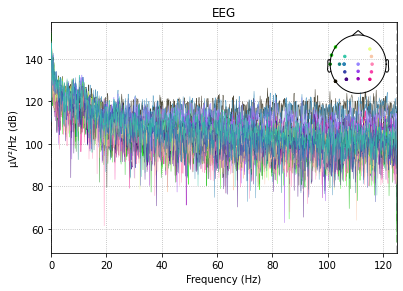

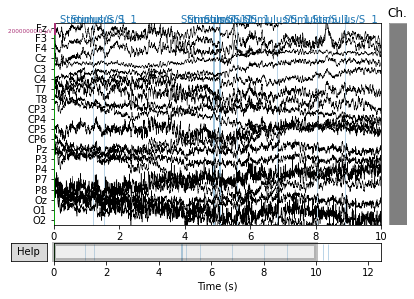

In [27]:
# 利用mne库做数据预处理及显示
raw = mne.io.read_raw_brainvision(vhdr_fname='data/s1.vhdr', preload=True)
# print(raw.info)

# 画eeg的功率谱密度
raw.plot_psd()
plt.show()

# 画20个通道波形
raw.plot(n_channels=20, scalings=10, title='all_signals',show=True, block=True)
plt.show()

In [68]:
estimation = pyriemann.estimation.Covariances(estimator='scm')
SPD_matrix = estimation.fit(np.expand_dims(np.transpose(np.array(data)), axis=0), 
                            np.expand_dims(np.array(event_data[:][1]), axis=0))
select = pyriemann.channelselection.ElectrodeSelection(nelec=15,metric='riemann')
remove = pyriemann.channelselection.FlatChannelRemover()
good_channels = remove.fit_transform(np.expand_dims(np.transpose(np.array(data)), axis=0))
print(good_channels.shape[1])

12
